In [1]:
%pip install -r requirements.txt
import pandas as pd
import numpy as np
import xgboost as xgb
import os
import tarfile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

Note: you may need to restart the kernel to use updated packages.


In [28]:
folder_path = "data"
# folder_path = "data_small"

In [29]:
def unarchive_and_read_tsv(prefix, tsv_filename):
    file_to_unarchive = None
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.tar.gz') and file_name.startswith(prefix):
            file_to_unarchive = os.path.join(folder_path, file_name)
            break

    if file_to_unarchive is None:
        print(f"No matching .tar.gz file found with prefix '{prefix}'.")
        return None

    archive_name = os.path.basename(file_to_unarchive)[:-7]
    unarchived_folder = os.path.join(folder_path, archive_name)
    if os.path.exists(unarchived_folder):
        print("File already unarchived.")
    else:
        with tarfile.open(file_to_unarchive, 'r:gz') as tar:
            tar.extractall(unarchived_folder)
        print("File unarchived successfully.")

    tsv_file = os.path.join(unarchived_folder, tsv_filename)
    dataframe = pd.read_csv(tsv_file, delimiter='\t')
    return dataframe


In [33]:
prefix = "clinical"
tsv_filename = "clinical.tsv"

clinical_df = unarchive_and_read_tsv(prefix, tsv_filename)

# Remove duplicate rows based on 'case_id' column
print(f'Shape before deduplication: {clinical_df.shape}')
clinical_df = clinical_df.drop_duplicates(subset='case_id', keep='first')
print(f'Shape after deduplication: {clinical_df.shape}')

print(clinical_df.head())

File unarchived successfully.
Shape before deduplication: (1731, 158)
Shape after deduplication: (822, 158)
                                case_id case_submitter_id project_id   
0  001ad307-4ad3-4f1d-b2fc-efc032871c7e      TCGA-HT-A614   TCGA-LGG  \
2  0061e9ef-df6a-414e-af64-c88f8192e2d3      TCGA-E1-5311   TCGA-LGG   
4  0073a136-d5f4-4fd6-88f9-711768f2abc6      TCGA-VM-A8CF   TCGA-LGG   
6  0078b0c4-68a9-483b-9aab-61156d263213      TCGA-14-1034   TCGA-GBM   
8  00b18ad6-ff70-41fe-8f4d-0763ac8f28b9      TCGA-HT-7677   TCGA-LGG   

  age_at_index age_is_obfuscated cause_of_death cause_of_death_source   
0           47               '--            '--                   '--  \
2           31               '--            '--                   '--   
4           44               '--            '--                   '--   
6           60               '--            '--                   '--   
8           53               '--            '--                   '--   

  country_of_residen

(array([232., 100.,  95.,  61.,  70.,  79.,  82.,  63.,  25.,  15.]),
 array([ 0. ,  7.1, 14.2, 21.3, 28.4, 35.5, 42.6, 49.7, 56.8, 63.9, 71. ]),
 <BarContainer object of 10 artists>)

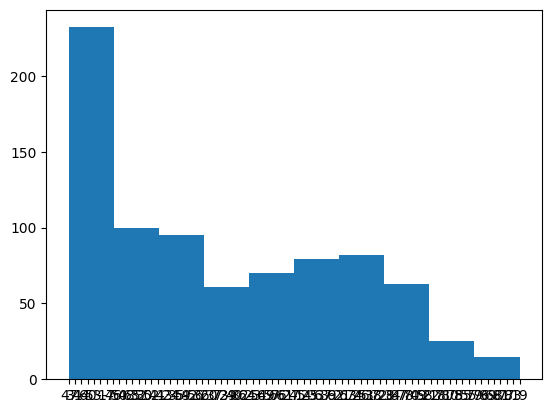

In [15]:
# extarcting the age column
age = clinical_df['age_at_index']
plt.hist(age, bins=10)

In [16]:
def parse_tsv_file(file_path):
    dataframe = pd.read_csv(file_path, delimiter='\t', comment='#')
    dataframe = dataframe[dataframe['gene_id'].str.startswith('ENSG')]
    dataframe = dataframe[['gene_id', 'tpm_unstranded']]
    dataframe = dataframe.set_index('gene_id').T
    return dataframe

In [44]:
def unarchive_and_build_dataframe(folder_path, prefix):
    file_to_unarchive = None
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.tar.gz') and file_name.startswith(prefix):
            file_to_unarchive = os.path.join(folder_path, file_name)
            break

    if file_to_unarchive is None:
        print(f"No matching .tar.gz file found with prefix '{prefix}'.")
        return None

    archive_name = os.path.basename(file_to_unarchive)[:-7]
    unarchived_folder = os.path.join(folder_path, archive_name)
    if os.path.exists(unarchived_folder):
        print("File already unarchived.")
    else:
        with tarfile.open(file_to_unarchive, 'r:gz') as tar:
            tar.extractall(unarchived_folder)
        print("File unarchived successfully.")

    dataframes = []
    for folder_name in os.listdir(unarchived_folder):
        folder_path = os.path.join(unarchived_folder, folder_name)
        if not os.path.isdir(folder_path):
            continue
        tsv_files = [f for f in os.listdir(folder_path) if f.endswith('.tsv')]
        if len(tsv_files) == 1:
            tsv_file = os.path.join(folder_path, tsv_files[0])
            dataframe = parse_tsv_file(tsv_file)
            dataframe.insert(0, 'case_id', [folder_name])
            dataframes.append(dataframe)

    if not dataframes:
        print("No .tsv files found.")
        return None

    combined_dataframe = pd.concat(dataframes, ignore_index=True)
    return combined_dataframe


In [45]:
prefix = "gdc_download"
data = None
data = unarchive_and_build_dataframe(folder_path, prefix)
# remove the first column
# data = data.iloc[:, 1:]
print(data)

File already unarchived.


In [37]:
K = 10
def train_xgboost_model(data, target):
    # Ignore the first column "gene_id"
    all_features = data.iloc[:, 1:]

    # perform feature selection
    test = SelectKBest(score_func=f_regression, k=K)
    features = test.fit_transform(all_features, target)


    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=42)

    # Train an XGBoost regression model
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")

    return model

In [39]:
print(data.shape)
print(age.shape)
model = train_xgboost_model(data, age)

(885, 60659)
(822,)


ValueError: Found input variables with inconsistent numbers of samples: [885, 822]

(array([ 1.,  0.,  0.,  0.,  0., 36.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([-5.65208817, -4.56833324, -3.48457832, -2.4008234 , -1.31706848,
        -0.23331356,  0.85044136,  1.93419628,  3.0179512 ,  4.10170612,
         5.18546104,  6.26921597,  7.35297089,  8.43672581,  9.52048073,
        10.60423565, 11.68799057, 12.77174549, 13.85550041, 14.93925533,
        16.02301025]),
 <BarContainer object of 20 artists>)

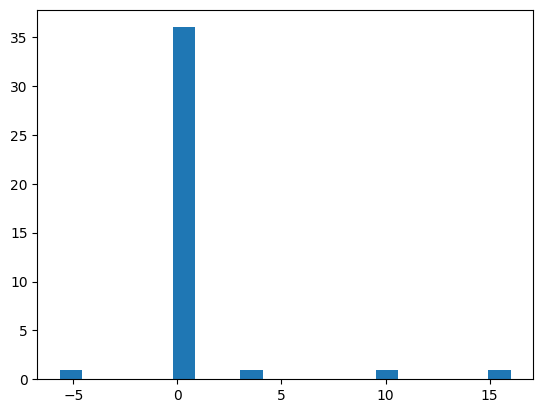

In [89]:
# perform feature selection
test = SelectKBest(score_func=f_regression, k=K)
features = test.fit_transform(data, clinical_df['age_at_index'])

predictions = model.predict(features)
results = pd.DataFrame({'Actual': clinical_df['age_at_index'], 'Predicted': predictions})
errors = results['Actual'] - results['Predicted']
plt.hist(errors, bins=20)

In [90]:
results

,Actual,Predicted
0,60,59.997631
2,31,31.000158
4,66,65.999825
6,67,67.000313
8,63,62.999725
10,72,72.000107
12,44,44.001785
14,56,56.000748
16,45,44.999760
18,70,69.997650
